# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC, SVC


# Hämtar data

In [2]:
mnist = fetch_openml('mnist_784', version = 1, cache = True, as_frame = False)
print (mnist.DESCR)

X = mnist["data"].astype("float32")
y = mnist["target"].astype(int)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

# Preprocessing

In [3]:
# Delar upp i train, validation, test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=10000, random_state=42, stratify=y)  # stratify - att varje siffra (0–9) får ungefär samma andel i varje låda.
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42, stratify=y_train_val)

preprocessor = StandardScaler()


# EDA

In [ ]:
# Visar fördelning av klasser, antal per siffra på train- och val-data. Ser ut att vara balanserat.

def class_summary(y, name): 
    counts = np.bincount(y, minlength=10)
    total = counts.sum()
    pct = counts / total * 100
    print(f"\n{name} - antal per siffra: ")
    for digit in range(10): 
        print(f"{digit}: {counts[digit]} ({pct[digit]:.1f}%)")

class_summary(y_train, "Train")
class_summary(y_val, "Validation")

counts_train = np.bincount(y_train, minlength=10)

plt.figure(figsize=(10, 6))
plt.bar(range(10), counts_train)
plt.xticks(range(10))
plt.title("Antal per klass i Train")
plt.xlabel("Number")
plt.ylabel("Count")
plt.show()

In [ ]:
# Visar ut slumpade siffror för att undersöka hur data-setet ser ut. 

random_numbers = np.random.choice(len(X_train), 10, replace=False)

plt.figure(figsize=(30, 30))
for i, j in enumerate(random_numbers, 1):
    plt.subplot(10, 10, i)
    plt.imshow(X_train[j].reshape(28, 28), cmap="grey")
    plt.title(str(y_train[j]))
    plt.axis("off")
plt.suptitle("10 slumpade bilder från Train", y=0.9)
plt.show()

In [ ]:
# Visar ut medelbild (typisk form för varje siffra) och standardavvikelse (hur mycket pixlarna varierar inom samma siffra) för att förstå datasetets mönster och var variationen är störst, vilket kan vara extra svårt för modeller att lära sig

def plot_per_digit_images(X, y, agg="mean", title=""):
    plt.figure(figsize=(12, 2))
    for digit in range(10):
        data = X[y == digit]
        img = getattr(data, agg)(axis=0).reshape(28, 28)  # mean eller std

        plt.subplot(1, 10, digit + 1)
        plt.imshow(img, cmap="gray")
        plt.title(digit)
        plt.axis("off")

    plt.suptitle(title, y=1)
    plt.tight_layout()
    plt.show()

plot_per_digit_images(X_train, y_train, agg="mean", title="Medelbild per siffra (Train)")
plot_per_digit_images(X_train, y_train, agg="std",  title="Standardavvikelse per siffra (Train)")


# Modeller

------------------------------------------------------------------------------------------------------------------------------------
### LogisticRegression
- LogisticRegression utan GridSearchCV: VAL accuracy: 0.9166
- LogisticRegression med GridSearchCV: Bästa C: {'model__C': 0.01}, Bästa CV-accuracy: 0.92086, VAL accuracy (best): 0.9269
__Slutsats__: __Låg accuracy, 0,917-0,927__, finns modeller som presterar bättre, lägger inte mer tid på denna. 

VAL accuracy (best): 0.9166


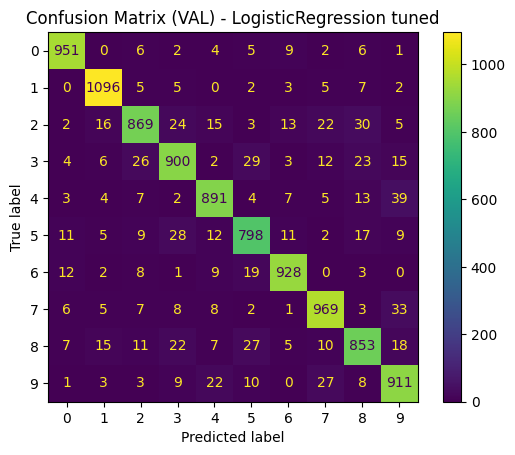

In [ ]:
pipe_lr = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=4000, solver="lbfgs"))
])


pipe_lr.fit(X_train, y_train)

# VAL-utvärdering
y_val_pred = pipe_lr.predict(X_val)
print("VAL accuracy (best):", accuracy_score(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - LogisticRegression tuned")
plt.show()

Bästa C: {'model__C': 0.01}
Bästa CV-accuracy: 0.92086
VAL accuracy (best): 0.9269


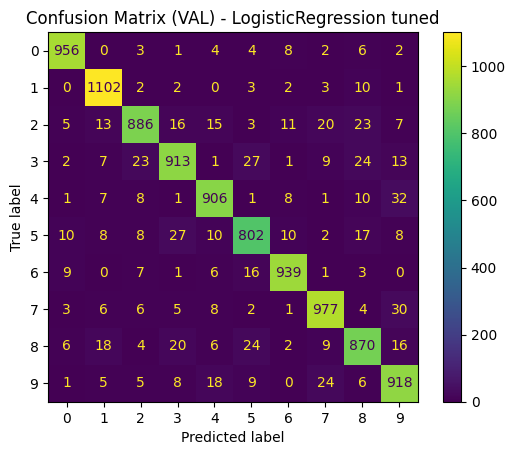

In [ ]:
pipe_lr_gs = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=4000, solver="lbfgs"))
])

hyperparam_grid__lr = {
    "model__C": [0.01, 0.05, 0.1, 0.2]
}

gs_lr = GridSearchCV(
    estimator=pipe_lr_gs,
    param_grid=hyperparam_grid__lr,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

gs_lr.fit(X_train, y_train)

print("Bästa C:", gs_lr.best_params_)
print("Bästa CV-accuracy:", gs_lr.best_score_)

best_model = gs_lr.best_estimator_

# VAL-utvärdering
y_val_pred = best_model.predict(X_val)
print("VAL accuracy (best):", accuracy_score(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - LogisticRegression tuned")
plt.show()

------------------------------------------------------------------------------------------------------------------------------------
### RandomForest
- RandomForest utan GridSearchCV: __VAL accuracy = 0.9724__
- RandomForest med GridSearchCV (bästa params: max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=500): __VAL accuracy = 0.9697__


RandomForest med standardinställningar gav högst VAL accracy i denna körning. Ingen tydlig förbättring med tuning av hyperparametrar. Det tyder på att standardparametrar redan är bra för detta dataset, att ytterligare tuning ger begränsad effekt i förhållande till den ökade beräkningskostnaden (upplevde att det tog mycket mer kapacitet från datorn vid tuning jämfört med standardvärden).

VAL accuracy (RandomForest): 0.9724


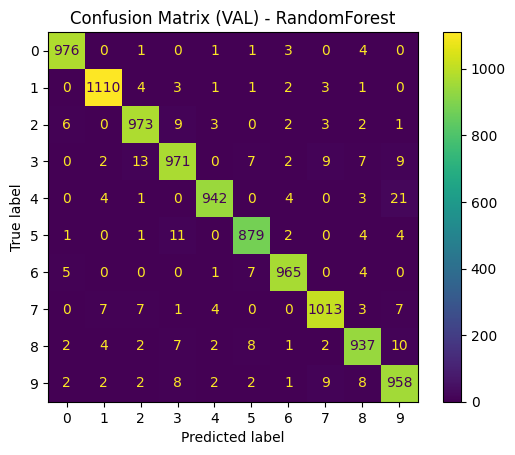

In [4]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

y_val_pred = rf.predict(X_val)
print("VAL accuracy (RandomForest):", accuracy_score(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - RandomForest")
plt.show()

VAL accuracy (RandomForest final): 0.9697


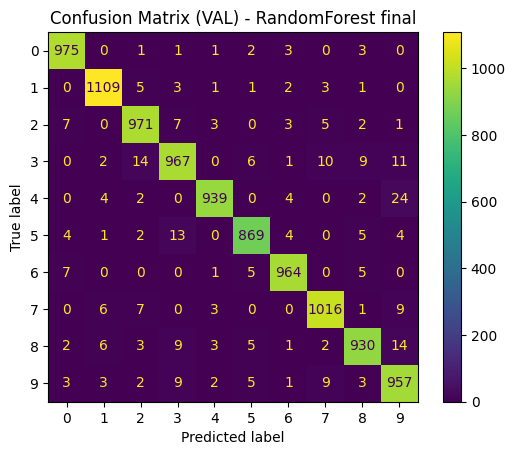

In [12]:
rf_final = RandomForestClassifier(
    random_state=42,
    n_jobs=1,
    bootstrap=True,
    max_samples=0.8,
    n_estimators=500,
    max_depth=20,
    max_features="sqrt",
    min_samples_leaf=1,
    min_samples_split=2
)

rf_final.fit(X_train, y_train)

y_val_pred = rf_final.predict(X_val)

val_acc = accuracy_score(y_val, y_val_pred)
print("VAL accuracy (RandomForest final):", val_acc)

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - RandomForest final")
plt.show()


------------------------------------------------------------------------------------------------------------------------------------
### LinearSVC
- LinearSVC (med C=1.0, max_iter=6000, tol=1e-3,dual="auto")): __VAL accuracy = 0.9137__

__Slutsats:__  LinearSVC tar alldeles för mycket lång tid och ger för dåligt resultat (låg acuracy) för att jag ska välja att gå vidare med modellen. 

VAL accuracy (LinearSVC): 0.9137


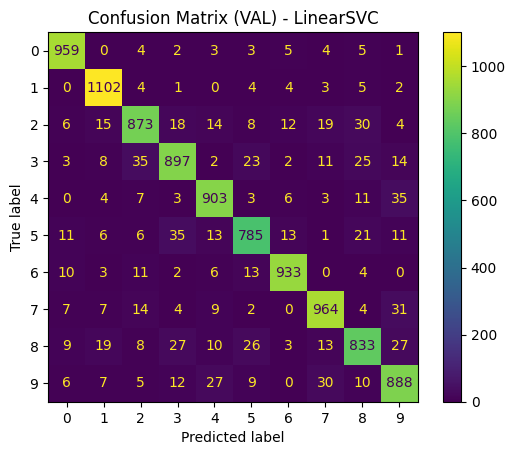

In [7]:
pipe_lsvc = Pipeline([
    ("prep", preprocessor),
    ("model", LinearSVC(C=1.0, max_iter=6000, tol=1e-3,dual="auto", random_state=42)) #har fått optimera bort tol=1e-3, dual="auto", minskat max_iter för att få modellen att köra klart inom rimlig tid. Testat mer bredd men tar då över 1h att köra och det hinner inte ens gå klart på min laptop. 
])

pipe_lsvc.fit(X_train, y_train)

# VAL-utvärdering
y_val_pred = pipe_lsvc.predict(X_val)
print("VAL accuracy (LinearSVC):", accuracy_score(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - LinearSVC")
plt.show()

------------------------------------------------------------------------------------------------------------------------------------
### SVC
- SVC utan GridSearchCV (RBF + PCA): __VAL accuracy (SVC): 0.9791__
- SVC med GridSearchCV (stegvis tuning av C, gamma och PCA): VAL accuracy (SVC tuned): ~0.9795–0.9796 (Bästa parametrar: PCA=75, gamma="scale", C=14): __VAL accuracy (SVC): 0.9795__

__Slutsats:__  SVC med RBF-kärna presterade stabilt och gav hög VAL-accuracy runt 0,9795. GridSearchCV gav bara en marginell förbättring jämfört med en rimlig standardinställning, och den bästa modellen blev PCA=75 + gamma="scale" + C=14. Med hänsyn till begränsade resurser på laptop avgränsades sökutrymmet, men resultaten var konsekventa över flera tester. 

VAL accuracy (SVC): 0.9791


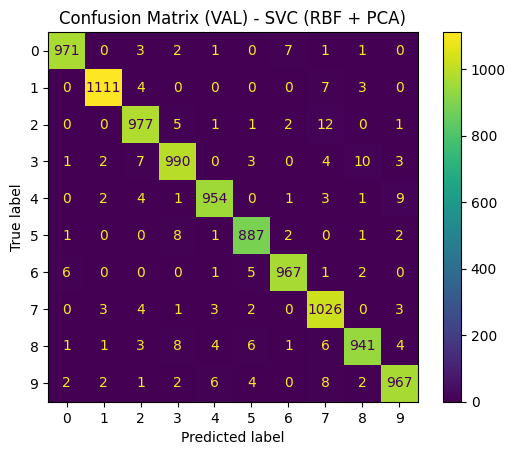

In [10]:
pipe_svc = Pipeline([
    ("scaler", preprocessor),
    ("pca", PCA(n_components=80, random_state=42)),
    ("svc", SVC(kernel="rbf", C=10, gamma="scale"))
])

pipe_svc.fit(X_train, y_train)

y_val_pred = pipe_svc.predict(X_val)
print("VAL accuracy (SVC):", accuracy_score(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - SVC (RBF + PCA)")
plt.show()


### Bästa PCA

In [8]:
pipe_step1 = Pipeline([
    ("scaler", preprocessor),
    ("pca", PCA(random_state=42)),
    ("model", SVC(kernel="rbf", C=10, gamma="scale", cache_size=2000))
])

param_grid_step1 = {
    "pca__n_components": [75, 76]
}

gs_step1 = GridSearchCV(
    estimator=pipe_step1,
    param_grid=param_grid_step1,
    cv=3,
    scoring="accuracy",
    n_jobs=2,
    pre_dispatch=2,
    verbose=2,
    return_train_score=False
)

gs_step1.fit(X_train, y_train)

BEST_PCA = gs_step1.best_params_["pca__n_components"]
print("STEG 1 - Bästa PCA:", BEST_PCA)
print("STEG 1 - Bästa CV-accuracy:", gs_step1.best_score_)



Fitting 3 folds for each of 2 candidates, totalling 6 fits
STEG 1 - Bästa PCA: 75
STEG 1 - Bästa CV-accuracy: 0.9729999087765755


### Bästa gamma och C

Fitting 3 folds for each of 9 candidates, totalling 27 fits

STEG 2 - Bästa params: {'model__C': 10, 'model__gamma': 'scale'}
STEG 2 - Bästa CV-accuracy: 0.9729999087765755

STEG 3 - Slutmodellparametrar:
PCA n_components: 75
C: 10
gamma: scale
VAL accuracy (final): 0.9794


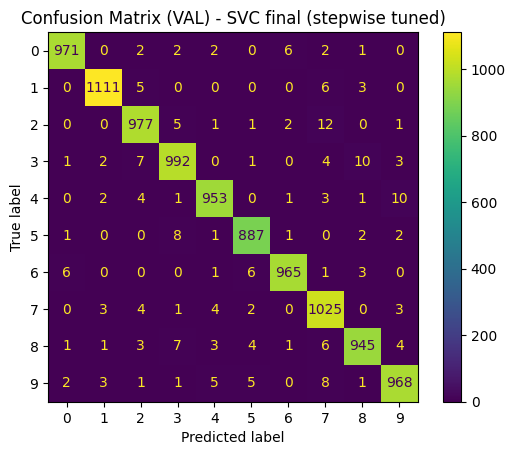

In [ ]:

BEST_PCA = 75

# ======== STEG 2: Hitta bästa gamma + C (med bästa PCA låst) ========
pipe_step2 = Pipeline([
    ("scaler", preprocessor),
    ("pca", PCA(BEST_PCA, random_state=42)),
    ("model", SVC(kernel="rbf", cache_size=2000))
])

param_grid_step2 = {
    "model__C": [3, 10, 30],
    "model__gamma": ["scale", 0.01, 0.03]
}

gs_step2 = GridSearchCV(
    estimator=pipe_step2,
    param_grid=param_grid_step2,
    cv=3,
    scoring="accuracy",
    n_jobs=2,
    pre_dispatch=2,
    verbose=2,
    return_train_score=False
)

gs_step2.fit(X_train, y_train)

BEST_C = gs_step2.best_params_["model__C"]
BEST_GAMMA = gs_step2.best_params_["model__gamma"]

print("\nSTEG 2 - Bästa params:", gs_step2.best_params_)
print("STEG 2 - Bästa CV-accuracy:", gs_step2.best_score_)

# ======== STEG 3: Slutmodell (utan GridSearch) + VAL-utvärdering ========
final_model = Pipeline([
    ("scaler", preprocessor),
    ("pca", PCA(n_components=BEST_PCA, random_state=42)),
    ("model", SVC(kernel="rbf", C=BEST_C, gamma=BEST_GAMMA, cache_size=2000))
])

final_model.fit(X_train, y_train)

y_val_pred = final_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)

print("\nSTEG 3 - Slutmodellparametrar:")
print("PCA n_components:", BEST_PCA)
print("C:", BEST_C)
print("gamma:", BEST_GAMMA)
print("VAL accuracy (final):", val_acc)

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - SVC final (stepwise tuned)")
plt.show()

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] END ........................................model__C=10; total time=  22.4s
[CV] END ........................................model__C=10; total time=  23.1s
[CV] END ........................................model__C=10; total time=  23.5s
[CV] END ........................................model__C=11; total time=  22.5s
[CV] END ........................................model__C=11; total time=  22.6s
[CV] END ........................................model__C=11; total time=  20.9s
[CV] END ........................................model__C=12; total time=  24.4s
[CV] END ........................................model__C=12; total time=  21.9s
[CV] END ........................................model__C=12; total time=  22.7s
[CV] END ........................................model__C=13; total time=  23.5s
[CV] END ........................................model__C=13; total time=  21.4s
[CV] END ........................................

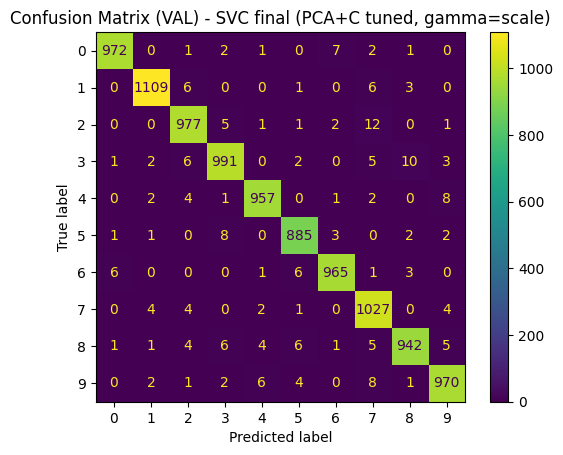

In [5]:
BEST_PCA = 75
BEST_GAMMA = "scale"

# ======== STEG 2: GridSearch över PCA + C (gamma låst) ========
pipe_step2 = Pipeline([
    ("scaler", preprocessor),
    ("pca", PCA(n_components=BEST_PCA, random_state=42, svd_solver="randomized")),
    ("model", SVC(kernel="rbf", gamma="scale", cache_size=500))
])

param_grid_step2 = {
    "model__C": [10, 11, 12, 13, 14, 15, 16]
}

gs_step2 = GridSearchCV(
    estimator=pipe_step2,
    param_grid=param_grid_step2,
    cv=3,
    scoring="accuracy",
    n_jobs=1,
    pre_dispatch=1,
    verbose=2,
    return_train_score=False
)

gs_step2.fit(X_train, y_train)


BEST_C = gs_step2.best_params_["model__C"]

print("\nSTEG 2 - Bästa params:", gs_step2.best_params_)
print("STEG 2 - Bästa CV-accuracy:", gs_step2.best_score_)

# ======== STEG 3: Slutmodell (utan GridSearch) + VAL-utvärdering ========
final_model = Pipeline([
    ("scaler", preprocessor),
    ("pca", PCA(n_components=BEST_PCA, random_state=42, svd_solver="randomized")),
    ("model", SVC(kernel="rbf", C=BEST_C, gamma=BEST_GAMMA, cache_size=500))
])

final_model.fit(X_train, y_train)

y_val_pred = final_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)

print("\nSTEG 3 - Slutmodellparametrar:")
print("PCA n_components:", BEST_PCA)
print("C:", BEST_C)
print("gamma:", BEST_GAMMA)
print("VAL accuracy (final):", val_acc)

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - SVC final (PCA+C tuned, gamma=scale)")
plt.show()


#### Slutreultat

Jag har testat mig fram på en laptop med begränsade resurser, vilket gjorde att vissa körningar tog lång tid. Därför behövde jag begränsa antalet parametrar och kombinationer i mina tester. Efter flera dagars experiment och utvärdering landade jag i följande slutmodell:

__Final model:__ SVC (RBF)

__Hyperparametrar:__
- gamma = "scale"
- PCA: n_components = 75
- C = 14

## Vald modell SVC

FINAL hyperparams:
  PCA = 75, C = 14, gamma = scale
TEST accuracy: 0.9768


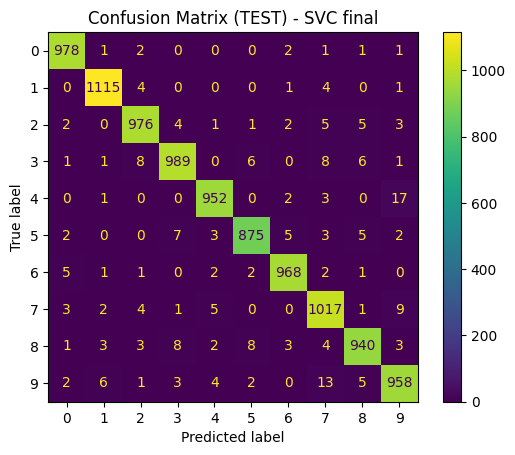

VAL accuracy: 0.9795


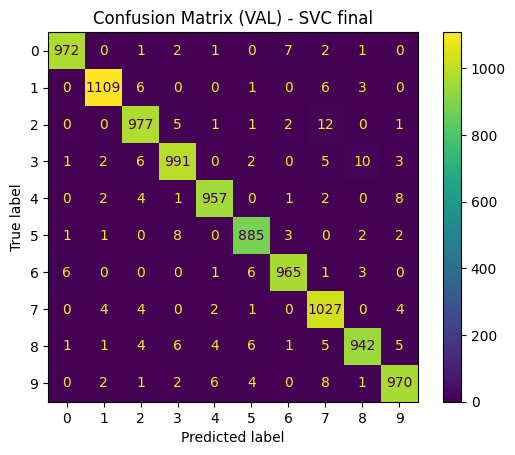

Accuracy on ALL data (in-sample): 0.9977


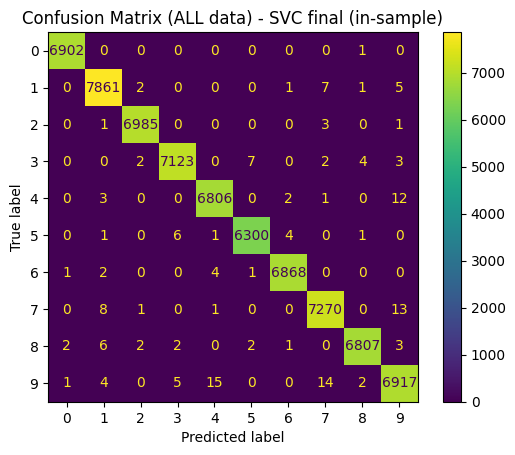

In [9]:
BEST_PCA = 75
BEST_C = 14
BEST_GAMMA = "scale"

final_model_svc = Pipeline([
    ("scaler", preprocessor),
    ("pca", PCA(n_components=BEST_PCA, random_state=42, svd_solver="randomized")),
    ("model", SVC(kernel="rbf", C=BEST_C, gamma=BEST_GAMMA, cache_size=500))
])

# Tränar på träningsdata och testar mot testdata
final_model_svc.fit(X_train, y_train)

y_test_pred = final_model_svc.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("FINAL hyperparams:")
print(f"  PCA = {BEST_PCA}, C = {BEST_C}, gamma = {BEST_GAMMA}")
print("TEST accuracy:", test_acc)

cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test).plot(values_format="d")
plt.title("Confusion Matrix (TEST) - SVC final")
plt.show()

# Får ut accuracy på validation-data
y_val_pred = final_model_svc.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print("VAL accuracy:", val_acc)

cm_val = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm_val).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - SVC final")
plt.show()

#Tränar på hela dataset och visar ut testresultat på Accuracy
final_model_svc.fit(X, y)

y_all_pred = final_model_svc.predict(X)
all_acc = accuracy_score(y, y_all_pred)
print("Accuracy on ALL data (in-sample):", all_acc)

cm_all = confusion_matrix(y, y_all_pred)
ConfusionMatrixDisplay(cm_all).plot(values_format="d")
plt.title("Confusion Matrix (ALL data) - SVC final (in-sample)")
plt.show()
